# **Ejemplo 1 : Aplicando funciones propias en un Pipeline**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer

np.random.seed(17)

In [ ]:
X = np.random.rand(200, 4)   # Datos 200x4 --> registrosXcolumnas. Aleatorios uniforme en [0,1)

# Definamos cualquier relación no-lineal entre ellas y le agregamos algo de ruido al final:
y = 2*X[:,0] + np.sin(X[:,1]*np.pi) + X[:,2]**2 - 0.1*X[:,3] + np.random.normal(0, 0.1, 200)

# Definimos como DataFrame de Pandas a X:
df = pd.DataFrame(X, columns=['X1', 'X2', 'X3', 'X4'])
df.head(3)

,X1,X2,X3,X4
0,0.294665,0.530587,0.191521,0.067900
1,0.786985,0.656334,0.637521,0.575603
2,0.039063,0.357814,0.945683,0.060045


In [ ]:
# Definamos una función cualquiera en una de las variables:

def mi_funcion(w):
     tmp = np.sqrt(w)


     return tmp

In [ ]:
# Partición:
X_train, X_test, y_train, y_test = train_test_split(df, y, train_size=0.8, random_state=1)



# Pipeline con transformaciones:
mi_pipeline = Pipeline(steps = [('impMediana', SimpleImputer(strategy='median')),
                             ('sqrt', FunctionTransformer(mi_funcion)),    # <<< Aquí puedes aplicar tu transformación definida
                             ])
mi_pipeline_nombres = ['X1']

colTransf = ColumnTransformer(transformers = [('ajuste', mi_pipeline, mi_pipeline_nombres)],
                              remainder='passthrough')


Xtrain = colTransf.fit_transform(X_train)
Xtest = colTransf.transform(X_test)


# Modelo de Regresión de SVM:
svr = SVR(kernel='rbf',
          C=10,        # Valores más grandes castiga más los errores. Valores grandes, penaliza más fuerte y
                      # por lo tanto peligro de sobreentrenamiento.
          gamma=0.1,    #"scale"   # gamma define el alcance de influencia de cada punto: gamma más grande, mayor ajuste y
                                   # serpentea (no quiere se se le espace ningún error, inclusive ruido lo analiza),
                                   # por ello el peligro de sobreentrenamiento.
          )

# Entrenamos, hacemos predicciones y calculamos error MSE:
svr.fit(Xtrain, y_train)
y_pred = svr.predict(Xtest)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: Error_cuadrático_medio: {mse:.3f}")

MSE: Error_cuadrático_medio: 0.061


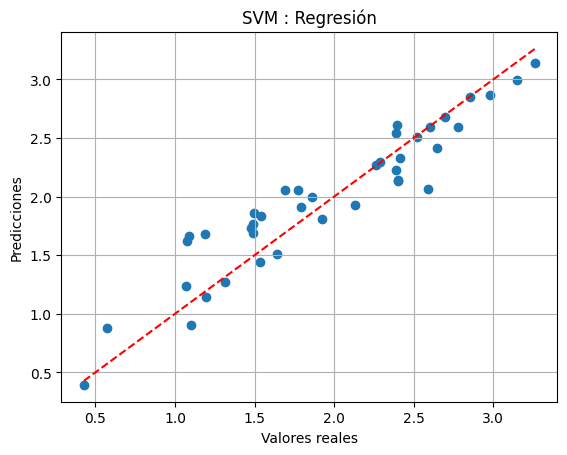

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Valores reales")
plt.ylabel("Predicciones")
plt.title("SVM : Regresión")
plt.grid(True)
plt.show()

# **Ejemplo 2 : Desbalanceo en problemas de Regresión**

https://www.statsmodels.org/stable/index.html

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
import statsmodels.api as sm   # Utilicemos esta otra librería muy utilizada en temas de Estadística
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
# Datos vía la librería sm:  https://www.statsmodels.org/stable/datasets/generated/fair.html

# Variable de salida: tiempo que se pasa en relación extramarital --> Problema de Regresión

data = sm.datasets.fair.load_pandas().data
print(data.shape)

(6366, 9)


In [ ]:
data.head(3)

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000


In [ ]:
data.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.705374
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,2.203374
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,0.484848
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,57.599991


array([[<Axes: title={'center': 'affairs'}>]], dtype=object)

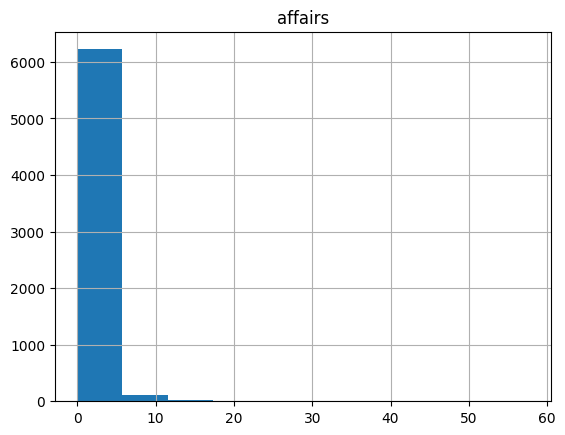

In [ ]:
data[['affairs']].hist()

<Axes: >

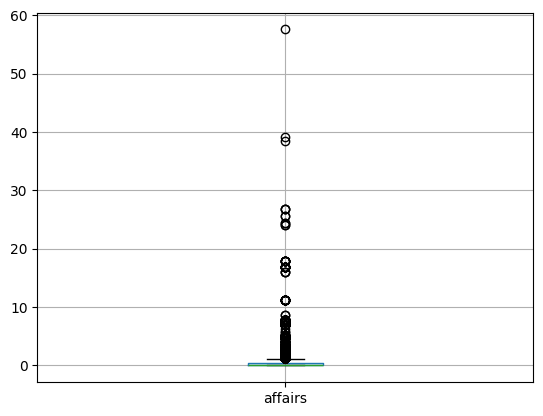

In [ ]:
data[['affairs']].boxplot()

In [ ]:
X = data.drop('affairs', axis=1)
y = data['affairs']

# Partición:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=17)

# Definamos nuestro umbral para casos atípicos/raros (conjunto desbalanceado):
umbral = 2
raros_train = y_train > umbral   # localizamos los indices de los casos atípicos

# Separemos los datos en típicos y atípicos (raros):
# Casos típicos:
X_tipicos = X_train[~raros_train]
y_tipicos = y_train[~raros_train]

# Casos atípicos:
X_raros = X_train[raros_train]
y_raros = y_train[raros_train]

print('Dimensión de los conjuntos de entrada Típicos y Atípicos:')
print('Train típicos:', len(y_tipicos))
print('Train raros:', len(y_raros))

Dimensión de los conjuntos de entrada Típicos y Atípicos:
Train típicos: 4005
Train raros: 451


In [ ]:
# Tomemos como modelo base el modelo sin balanceo (baseline)
model = sm.OLS(y_train, sm.add_constant(X_train))
result = model.fit()
pred = result.predict(sm.add_constant(X_test))
mse = mean_squared_error(y_test, pred)

# MSE en raros del test
raros_test = y_test > umbral
mse_raros = mean_squared_error(y_test[raros_test], pred[raros_test])

print('Modelo base (baseline) MSE:', mse)
print('Modelo base (baseline) MSE raros:', mse_raros)

Modelo base (baseline) MSE: 5.242975046301388
Modelo base (baseline) MSE raros: 50.021485146040575


## **Submuestreo : caso Regresión**

In [ ]:
# Submuestreo (undersampling)
# Seleccionamos en el conjunto más grande la misma cantidad del conjunto
# más pequeño y ese será nuestro nuevo conjunto:
if len(y_tipicos) > len(y_raros):
    sample_idx = np.random.choice(len(y_tipicos), len(y_raros), replace=False)
    X_sub = pd.concat([X_tipicos.iloc[sample_idx], X_raros])
    y_sub = pd.concat([y_tipicos.iloc[sample_idx], y_raros])
else:
    X_sub = pd.concat([X_tipicos, X_raros])
    y_sub = pd.concat([y_tipicos, y_raros])

model_sub = sm.OLS(y_sub, sm.add_constant(X_sub))
result_sub = model_sub.fit()
pred_sub = result_sub.predict(sm.add_constant(X_test))

mse_sub = mean_squared_error(y_test, pred_sub)
mse_sub_raros = mean_squared_error(y_test[raros_test], pred_sub[raros_test])

print('Sub-muestreo MSE:', mse_sub)
print('Sub-muestreo MSE raros:', mse_sub_raros)

Sub-muestreo MSE: 9.204439218771057
Sub-muestreo MSE raros: 35.98314528653006


## **Sobremuestreo : caso Regresión**

In [ ]:
# Sobremuestreo

multiplo = 5  # Ahora duplicamos los casos atípicos/raros el múltiplo de veces indicado (hiperparámetro)
X_sob = pd.concat([X_tipicos] + [X_raros] * multiplo)
y_sob = pd.concat([y_tipicos] + [y_raros] * multiplo)

model_sob = sm.OLS(y_sob, sm.add_constant(X_sob))
result_sob = model_sob.fit()
pred_sob = result_sob.predict(sm.add_constant(X_test))
mse_sob = np.mean((pred_sob - y_test)**2)
mse_sob_raros = np.mean((pred_sob[raros_test] - y_test[raros_test])**2) if raros_test.any() else np.nan

print('Sobremuestreo MSE:', mse_sob)
print('Sobremuestreo MSE raros:', mse_sob_raros)

Sobremuestreo MSE: 7.100938841123211
Sobremuestreo MSE raros: 39.1801187096955
